In [1]:
import pandas, numpy, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.backend import clear_session
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

exchange rates and quotes from https://www.quandl.com/collections

experimentos:

- selecciona distintos grupos de señales de entrada
- añade unidades/capas la la RNN (usa `return_sequences=True` en la primera capa si usas más capas)
- observa la velocidad de convergencia respecto al número de señales de entrada, tamaño del batch, etc.

In [2]:
forex = {}
forex["usdeur"] = pd.read_csv("data/quandl/CURRFX-USDEUR.csv.gz", compression="gzip")
forex["usdbrl"] = pd.read_csv("data/quandl/CURRFX-USDBRL.csv.gz", compression="gzip")
forex["usdgbp"] = pd.read_csv("data/quandl/CURRFX-USDGBP.csv.gz", compression="gzip")
forex["usdjpy"] = pd.read_csv("data/quandl/CURRFX-USDJPY.csv.gz", compression="gzip")
forex["usdkwd"] = pd.read_csv("data/quandl/CURRFX-USDKWD.csv.gz", compression="gzip")
forex["usdmxn"] = pd.read_csv("data/quandl/CURRFX-USDMXN.csv.gz", compression="gzip")
forex["usdrub"] = pd.read_csv("data/quandl/CURRFX-USDRUB.csv.gz", compression="gzip")
forex["usdsar"] = pd.read_csv("data/quandl/CURRFX-USDSAR.csv.gz", compression="gzip")
forex["usdsek"] = pd.read_csv("data/quandl/CURRFX-USDSEK.csv.gz", compression="gzip")
forex["oilbrt"] = pd.read_csv("data/quandl/EIA-PET_RBRTE_D.csv.gz", compression="gzip")

In [3]:
forex["usdeur"].head()

,Date,Rate,High (est),Low (est)
0,2017-03-16,0.9309,0.9311,0.9305
1,2017-03-15,0.9311,0.9422,0.9309
2,2017-03-14,0.9421,0.9431,0.9378
3,2017-03-13,0.9386,0.9391,0.9332
4,2017-03-10,0.9367,0.9450,0.9344


In [4]:
forex["usdbrl"].head()

,Date,Rate,High (est),Low (est)
0,2017-03-15,3.1028,3.1780,3.0973
1,2017-03-14,3.1638,3.1817,3.1495
2,2017-03-13,3.1518,3.1600,3.1244
3,2017-03-10,3.1378,3.1930,3.1378
4,2017-03-09,3.1925,3.1974,3.1595


### Clean and standardize data

In [5]:
def moving_avg(s, wsize=10):
    r = np.zeros(len(s)-wsize)
    for i in range(len(r)):
        r[i] = np.mean(s[i:i+wsize])
    return r

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalers = {}
min_date = pd.Timestamp("2000-01-01")
max_date = pd.Timestamp("2100-01-01")
wsize = 10

for k in forex.keys():
    asset = forex[k]
    scalers[k] = MinMaxScaler(feature_range=(0,1))
    
    if "Rate" in asset.columns:
        asset["Value"] = asset["Rate"]
    asset["Date"] = pd.to_datetime(asset.Date)
    asset["Value"] = scalers[k].fit_transform(asset["Value"].values.reshape(-1,1)).reshape(-1,1)
    dmin, dmax = np.min(asset.Date), np.max(asset.Date)
    min_date = dmin if dmin>min_date else min_date
    max_date = dmax if dmax<max_date else max_date
    
for k in forex.keys():
    forex[k] = forex[k][ (forex[k].Date>=min_date) & (forex[k].Date<=max_date) ].copy()
    forex[k].index = forex[k].Date
    forex[k] = forex[k].sort_index()[["Date", "Value"]]
    

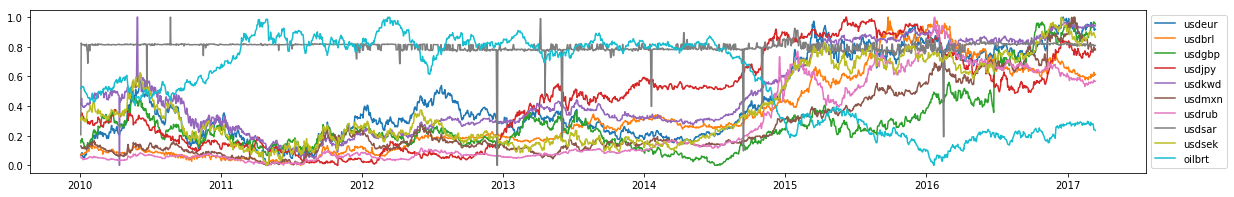

In [7]:
plt.figure(figsize=(20,3))
for k in forex.keys():
    plt.plot(forex[k].Date, forex[k].Value, label=k)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

builds multisignal framed dataset

In [8]:
def build_sequences(signal, seq_len):
    result = []
    for index in range(len(signal) - seq_len):
        result.append(signal[index: index + seq_len])
    result = np.array(result)  
    return result


In [15]:
def build_multisignal_keras_sequences(data, assets, wsize=None, seq_len=5):
    """
    assumes all dataframes in data dictionary have a column "Value" holding the signal
    and are date indexed 
    """
    data = {k:v.copy() for k,v in forex.items() if k in assets}
    
    # smoothing if required
    if wsize is not None and wsize>0:
        for k in data.keys():
            s = data[k].Value
            data[k] = data[k].iloc[wsize:]
            data[k].Value = moving_avg(s, wsize)    

    # date alignment and remove missing dates
    common_dates = data[assets[0]].index
    for i in range(1, len(assets)):
        common_dates = common_dates.join(data[assets[i]].index, how="inner")

    fdata  = {i: data[i].copy().loc[common_dates] for i in assets}
    
    # build sequence frames
    keys = list(fdata.keys())
    r = np.empty((fdata[keys[0]].shape[0]-seq_len, seq_len, len(fdata)))
    for i,k in enumerate(keys):
        r[:,:,i] = build_sequences(fdata[k].Value, seq_len)
    return fdata, common_dates[seq_len:], r

In [19]:
assets = ["usdeur", "usdmxn", "usdbrl", "oilbrt", "usdrub", "usdsar", "usdjpy", "usdgbp"]
assets = [ "usdmxn", "oilbrt"]
seq_len, wsize = 10, 5
fdata, dates, r = build_multisignal_keras_sequences(forex, assets, wsize=wsize, seq_len=seq_len)

In [20]:
dates.shape, r.shape

((1806,), (1806, 10, 2))

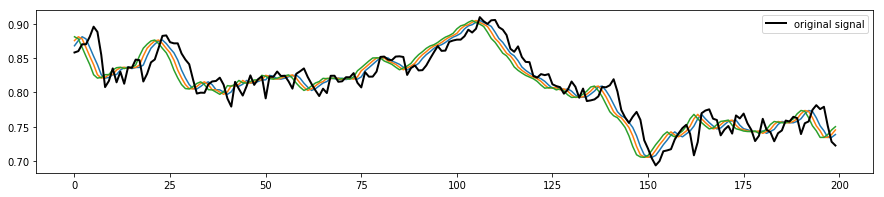

In [21]:
start = np.random.randint(len(r))
end = start+200
plt.figure(figsize=(15,3))
plt.plot(r[start:end,0,1])
if wsize>1:
    plt.plot(r[start:end,1,1])
if wsize>2:
    plt.plot(r[start:end,2,1])
plt.plot(forex["oilbrt"].Value.values[start:end],lw=2, color="black", label="original signal")
plt.legend()

In [57]:
train_pct = 0.3
row = int(train_pct * len(r))

symbol_to_predict = "usdmxn"
signal_to_predict = np.argwhere(np.array(list(fdata.keys()))==symbol_to_predict)[0][0]
print("predicting signal:", list(fdata.keys())[signal_to_predict])
X = r[:,:-1,:]
y = r[:,-1,signal_to_predict]


X_train, y_train = X[:row], y[:row]
X_test, y_test   = X[row:], y[row:]
print(X_train.shape, X_test.shape)

predicting signal: usdmxn
(541, 9, 2) (1265, 9, 2)


In [58]:
print(X[:,-1,signal_to_predict])
print(y)

[0.11813217 0.12791268 0.13208129 ... 0.80036854 0.78803538 0.78473043]
[0.12791268 0.13208129 0.13433835 ... 0.78803538 0.78473043 0.78143313]


check `y` is one of the signals advanced one time step

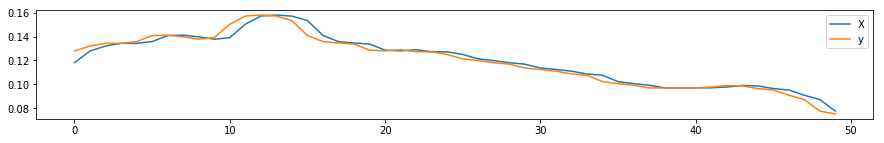

In [59]:
plt.figure(figsize=(15,2))
plt.plot(X[:50,-1,signal_to_predict], label="X")
plt.plot(y[:50], label="y")
plt.legend()

build lstm

In [60]:
X.shape[1:]

(9, 2)

In [61]:
clear_session()
model = Sequential()
lstm_unit_size=6
model.add(LSTM(units=lstm_unit_size, input_shape=X.shape[1:], activation="sigmoid", 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=10))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
init_weights = model.get_weights()

In [62]:
h = model.fit(X_train, y_train, epochs=20, batch_size=2, validation_split=.05, verbose=1)

Train on 513 samples, validate on 28 samples
Epoch 1/20
513/513 [==============================] - 2s 5ms/sample - loss: 0.0060 - val_loss: 2.0015e-04
Epoch 2/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0041 - val_loss: 4.0173e-04
Epoch 3/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0041 - val_loss: 2.2309e-04
Epoch 4/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0038 - val_loss: 5.9590e-04
Epoch 5/20
513/513 [==============================] - 1s 3ms/sample - loss: 0.0037 - val_loss: 2.7871e-04
Epoch 6/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0035 - val_loss: 6.5371e-04
Epoch 7/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0035 - val_loss: 1.8193e-04
Epoch 8/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0034 - val_loss: 6.5790e-04
Epoch 9/20
513/513 [==============================] - 2s 3ms/sample - loss: 0.0032 - val_loss: 1.4211e-04
E

Text(0.5, 1.0, 'last 100 epochs')

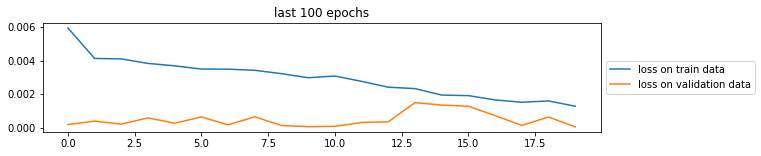

In [66]:
plt.figure(figsize=(10,2))
plt.plot(h.history["loss"][-100:], label="loss on train data")
plt.plot(h.history["val_loss"][-100:], label="loss on validation data")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("last 100 epochs")
#plt.ylim([0,np.max(list(h.history["val_loss"])+list(h.history["loss"]))])

In [67]:
train_predict = model.predict(X_train)[:,0]
test_predict = model.predict(X_test)[:,0]
from sklearn.metrics import mean_squared_error
print("MSE train %.7f"%mean_squared_error(train_predict, y_train))
print("MSE test  %.7f"%mean_squared_error(test_predict, y_test))

MSE train 0.0006946
MSE test  0.0322025


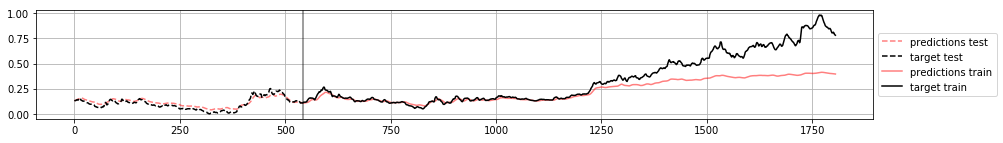

In [68]:
plt.figure(figsize=(15,2))
plt.plot(train_predict, label="predictions test", color="red", alpha=.5, ls="--")
plt.plot(y_train, label="target test", color="black", ls="--")
plt.legend(loc="center left", bbox_to_anchor=(1,.5))

plt.plot(range(len(y_train), len(y_train)+len(y_test)), test_predict, color="red", alpha=.5,  label="predictions train")
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test,  color="black", label="target train")
plt.legend(loc="center left", bbox_to_anchor=(1,.5))
plt.axvline(len(y_train), color="black", alpha=.5)
plt.grid();

### TREND PREDICTION!!

In [71]:
np.mean((y_train[1:]>y_train[:-1])==(train_predict[1:]>train_predict[:-1]))

0.6166666666666667

In [72]:
np.mean((y_test[1:]>y_test[:-1])==(test_predict[1:]>test_predict[:-1]))

0.6170886075949367